In [2]:
from src.reachability_analysis.simulation import get_test_config, get_test_label, get_cluster, get_initial_conditions, reachability_for_all_modes
from src.reachability_analysis.labeling_oracle import LabelingOracleSVEAData
from src.datasets.data import SVEAData, ROSData, SINDData
from src.transformer_model.model import create_model, evaluate
import json
import logging
import os
import rospy
from torch.utils.data import DataLoader
from src.datasets.data import data_factory, Normalizer
from src.datasets.masked_datasets import collate_unsuperv
from src.utils.load_data import load_task_datasets
from src.clustering.NearestNeighbor import AnnoyModel

logging.basicConfig(
    format="%(asctime)s | %(levelname)s : %(message)s", level=logging.INFO
)
logger = logging.getLogger(__name__)

/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/pypolycontain/operations.py:23: UserWarning: You don't have pydrake installed properly. Methods that rely on optimization may fail.
  warnings.warn("You don't have pydrake installed properly. Methods that rely on optimization may fail.")
/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/pypolycontain/conversions.py:19: UserWarning: WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.
  warnings.warn("WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.")
/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/pypolycontain/conversions.py:32: UserWarning: You don't have pydrake installed properly. Methods that rely on optimization may fail.
  warnings.warn("You don't have pydrake installed properly. Methods that rely on optimization may fail.")
/home/sam/Desktop/P

In [3]:
config_path = '/home/sam/Desktop/Pedestrian_Project/config-ros.json'

with open(config_path) as cnfg:
    config = json.load(cnfg)

ROOT_RESOURCES = os.getcwd() + "/resources"


config['original_data'] = False

config_test = config.copy()
config_test['online_data'] = True
config_test['online_data'] = False
config_test['pattern'] = None
config_test['data_dir'] = '/home/sam/Desktop/Pedestrian_Project/bags'
config_test['data_class'] = 'svea'
config_test['eval_only'] = True
config_test['val_ratio'] = 1

In [4]:
data_oracle = ROSData(config_test)


2024-07-10 10:51:50,273 | INFO : Loading 8 datasets files using 8 parallel processes ...


[INFO]  Data folder /home/sam/Desktop/Pedestrian_Project/bags/ismir_data_2024-06-28-11-56-17 already exists. Not creating.
[INFO]  Data folder /home/sam/Desktop/Pedestrian_Project/bags/ismir_data_2024-06-28-11-57-29 already exists. Not creating.
[INFO]  Data folder /home/sam/Desktop/Pedestrian_Project/bags/ismir_data_2024-06-28-13-48-57 already exists. Not creating.
[INFO]  Data folder /home/sam/Desktop/Pedestrian_Project/bags/ismir_data_2024-06-28-13-00-41 already exists. Not creating.
[INFO]  Data folder /home/sam/Desktop/Pedestrian_Project/bags/ismir_data_2024-06-28-13-17-08 already exists. Not creating.
[INFO]  Data folder /home/sam/Desktop/Pedestrian_Project/bags/ismir_data_2024-06-28-13-40-07 already exists. Not creating.
[INFO]  Data folder /home/sam/Desktop/Pedestrian_Project/bags/ismir_data_2024-06-28-14-10-40 already exists. Not creating.
[INFO]  Data folder /home/sam/Desktop/Pedestrian_Project/bags/ismir_data_2024-06-28-13-30-20 already exists. Not creating.


In [5]:
# online_Data = DataLoader(
#     dataset=data_oracle.all_df,
#     batch_size=config["batch_size"],
#     shuffle=False,
#     num_workers=config["num_workers"],
#     pin_memory=True,
#     collate_fn=lambda x: collate_fn(x, max_len=data_oracle.max_seq_len),
# )

val_data = data_oracle.feature_df

# Pre-process features
if config_test["data_normalization"] != "none":
    logger.info("Normalizing data ...")
    normalizer = Normalizer(config_test["data_normalization"])
    val_data = normalizer.normalize(val_data)


task_dataset, collate_fn = load_task_datasets(config_test)
val_dataset = task_dataset(data_oracle.feature_df, data_oracle.all_IDs)

# Dataloaders
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=config_test["num_workers"],
    pin_memory=True,
    collate_fn=lambda x: collate_fn(x, max_len=data_oracle.max_seq_len),
)

In [18]:
val_data.iloc[:50].to_numpy()

array([[-1.67262663e+02,  7.85363895e-01,  2.74343917e-03,
        -6.94599495e-03,  3.79001582e-03, -9.87498125e-03],
       [-1.67262535e+02,  7.94728590e-01,  1.11720678e-02,
        -7.21114657e-03,  2.57557235e-02, -1.13656860e-02],
       [-1.67245765e+02,  7.95070866e-01, -8.22149499e-04,
         1.71594805e-02, -1.33537197e-03,  3.63284425e-02],
       [-1.67245569e+02,  7.95310388e-01, -3.06809532e-03,
         1.00098110e-02, -3.37231775e-03,  2.59671305e-02],
       [-1.67245516e+02,  7.95376922e-01, -7.78733513e-03,
         1.73725465e-02, -1.58619481e-02,  3.30909631e-02],
       [-1.67245380e+02,  7.95545657e-01, -1.15304856e-02,
         1.74951736e-02, -9.76332333e-03,  3.29084839e-02],
       [-1.67252514e+02,  7.95378510e-01, -8.93056742e-03,
         9.87568745e-03, -1.05942227e-02,  2.21062960e-02],
       [-1.67252379e+02,  7.95554530e-01, -1.61787281e-02,
         1.00996743e-02, -1.92724431e-02,  2.23724030e-02],
       [-1.67252412e+02,  7.95512488e-01, -1.295

In [7]:
config_test['eval_only']

True

In [8]:
model, optimizer, trainer, val_evaluator, start_epoch = create_model(
    config_test, None, val_loader, data_oracle, logger, device='cpu'
)

/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-07-10 10:51:59,824 | INFO : Model:
TSTransformerEncoder(
  (project_inp): Linear(in_features=6, out_features=128, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Li

In [9]:
trainer, val_evaluator.dataloader

(<src.transformer_model.model.UnsupervisedAttentionModel at 0x7fc03a776c40>,
 <torch.utils.data.dataloader.DataLoader at 0x7fbf3d60d5e0>)

In [10]:
config_test['eval_only'] = True
config_test['val_ratio'] = 1

In [11]:
val_evaluator.evaluate

<bound method UnsupervisedAttentionModel.evaluate of <src.transformer_model.model.UnsupervisedAttentionModel object at 0x7fc03a776a30>>

In [12]:
aggr_metrics, embedding_data = evaluate(val_evaluator, config=config_test, save_embeddings=True)


Evaluating   0.0% | batch:         0 of      1038	|	loss: 106247
Evaluating   0.1% | batch:         1 of      1038	|	loss: 114691
Evaluating   0.2% | batch:         2 of      1038	|	loss: 112465
Evaluating   0.3% | batch:         3 of      1038	|	loss: 106239
Evaluating   0.4% | batch:         4 of      1038	|	loss: 102017
Evaluating   0.5% | batch:         5 of      1038	|	loss: 106240
Evaluating   0.6% | batch:         6 of      1038	|	loss: 112583
Evaluating   0.7% | batch:         7 of      1038	|	loss: 106240
Evaluating   0.8% | batch:         8 of      1038	|	loss: 114687
Evaluating   0.9% | batch:         9 of      1038	|	loss: 106220
Evaluating   1.0% | batch:        10 of      1038	|	loss: 91458.6
Evaluating   1.1% | batch:        11 of      1038	|	loss: 108350
Evaluating   1.2% | batch:        12 of      1038	|	loss: 106250
Evaluating   1.3% | batch:        13 of      1038	|	loss: 106249
Evaluating   1.3% | batch:        14 of      1038	|	loss: 106243
Evaluating   1.4% | batc

2024-07-10 10:52:05,511 | INFO : Evaluation Summary: loss: 56786.730734 | 
2024-07-10 10:52:05,514 | INFO : Evaluation runtime: 0.0 hours, 0.0 minutes, 3.9505701065063477 seconds



In [13]:
config_test['online_data'] = True
config_test['output_dir'] = 'experiments/ROS_experiment_2024-07-08_16-51-06_FOz/eval'

In [14]:
nn_model = AnnoyModel(config=config_test)


cluster_assignments = []
for e in embedding_data['embeddings']:
    cluster_assignments.append(nn_model.get(e))


Load data from: experiments/ROS_experiment_2024-07-08_16-51-06_FOz/eval/clusters
Load Annoy Model from: experiments/ROS_experiment_2024-07-08_16-51-06_FOz/eval/clusters/annoy_index.ann
Load Annoy Model from: experiments/ROS_experiment_2024-07-08_16-51-06_FOz/eval/clusters/annoy_index.ann
Load Annoy Model from: experiments/ROS_experiment_2024-07-08_16-51-06_FOz/eval/clusters/annoy_index.ann
Load Annoy Model from: experiments/ROS_experiment_2024-07-08_16-51-06_FOz/eval/clusters/annoy_index.ann
Load Annoy Model from: experiments/ROS_experiment_2024-07-08_16-51-06_FOz/eval/clusters/annoy_index.ann
Load Annoy Model from: experiments/ROS_experiment_2024-07-08_16-51-06_FOz/eval/clusters/annoy_index.ann
Load Annoy Model from: experiments/ROS_experiment_2024-07-08_16-51-06_FOz/eval/clusters/annoy_index.ann
Load Annoy Model from: experiments/ROS_experiment_2024-07-08_16-51-06_FOz/eval/clusters/annoy_index.ann
Load Annoy Model from: experiments/ROS_experiment_2024-07-08_16-51-06_FOz/eval/clusters

In [15]:
config_test['pattern']

Load data from: experiments/ROS_experiment_2024-07-08_16-51-06_FOz/eval/clusters
Load Annoy Model from: experiments/ROS_experiment_2024-07-08_16-51-06_FOz/eval/clusters/annoy_index.ann
[-167.25073       0.77537465] [0.02687914 0.00389804]
(1, 'Cluster: 1') 39 (715, 50, 6) (715,)


/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]
Calculating reachable sets: 100%|██████████| 48/48 [00:03<00:00, 12.36it/s]


Area of zonotope:  9841.8992  m^2
Load Annoy Model from: experiments/ROS_experiment_2024-07-08_16-51-06_FOz/eval/clusters/annoy_index.ann
[-167.2383        0.78598493] [-0.01166367  0.00965911]
(1, 'Cluster: 1') 39 (715, 50, 6) (715,)


/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]
Calculating reachable sets:  69%|██████▉   | 33/48 [00:02<00:01, 12.18it/s]


KeyboardInterrupt: 

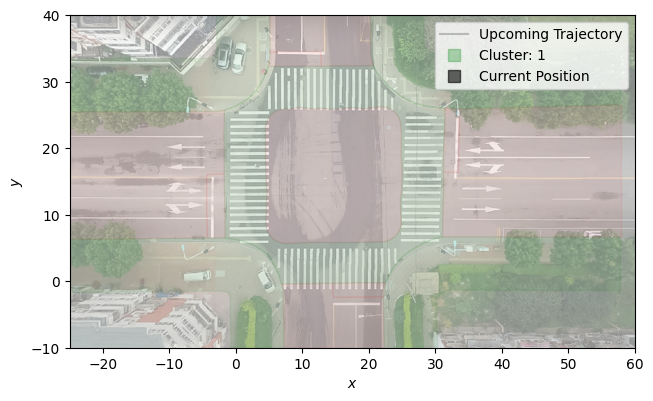

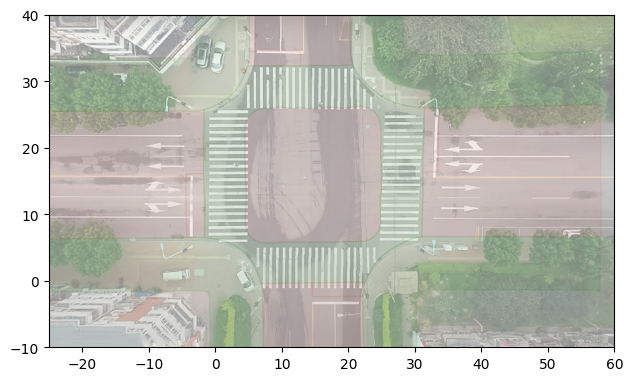

In [16]:
output = []
nn_model = AnnoyModel(config=config_test)

for embedding, target in zip(embedding_data['embeddings'], embedding_data['targets']):
    c = nn_model.get(e)
    test_cases = {f'c_{c}': f'Cluster: {c}'}
    pos, v = get_initial_conditions(target)
    print(pos, v)
    labeling_oracle = LabelingOracleSVEAData(config_test)
    z, l, _b, _z = reachability_for_all_modes(pos=pos, vel=v, baseline=False, test_cases=test_cases, config=config_test, trajectory=target, show_plot=False, save_plot=None, _sind = labeling_oracle)
    # TODO why above did I have to move the .pkl files to resources
    output.append(z[0])